<a href="https://colab.research.google.com/github/nomppy/colab-notebooks/blob/main/beam_net_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown 1v7FqhBh61LwpWFIWY1MMPDzI-GB9xcg7
!pip install tinycudann-1.7-cp310-cp310-linux_x86_64.whl
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!apt install nvidia-cuda-toolkit --yes

In [23]:
import torch
from torch import nn
# import tinycudann as tcnn
from tqdm import tqdm

import torchvision
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Literal, Sequence
from collections import OrderedDict

from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output, display
%load_ext tensorboard
# %tensorboard --logdir=logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
writer = SummaryWriter()

# fitting to sinuisoidal function

torch.Size([500, 1]) torch.Size([500, 1])


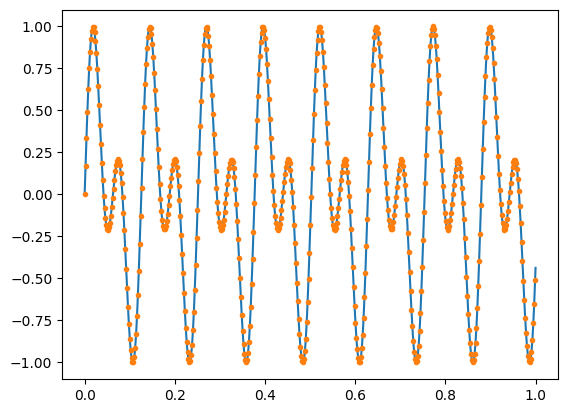

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_test = torch.linspace(0, 1, 1000).unsqueeze(-1)
omegas = [100, 50]
Y_test = torch.zeros_like(X_test)
for omega in omegas:
  Y_test += torch.sin(omega*X_test)

Y_test = Y_test / torch.max(Y_test)

train_data = [X_test[::2].to(device), Y_test[::2].to(device)]
print(train_data[0].shape, train_data[1].shape)

plt.plot(X_test, Y_test)
plt.plot(train_data[0].cpu(), train_data[1].cpu(), '.')
plt.show()


##mlp
Furst, we'll try to fit this function using a normal MLP with ~16M parameters

In [ ]:
class NormalMLP(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims,
               activation=nn.ReLU()):
    super().__init__()
    layers = []

    curr_dim = input_dim
    for dim in hidden_dims:
        layers.append(nn.Linear(curr_dim, dim))
        layers.append(activation)
        curr_dim = dim

    final_linear = nn.Linear(curr_dim, output_dim)
    layers.append(final_linear)

    self.net = nn.Sequential(*layers)

  def forward(self, x):
      return self.net(x)

In [ ]:
# model = torchvision.ops.MLP(1, [256, 256, 256, 256, 1])
model = NormalMLP(1, 1, [2048]*5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()

epochs = 10000

model = model.to(device)

print(np.sum([p.numel() for p in model.parameters()]))

16791553


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0 | Loss: 1.0033000707626343


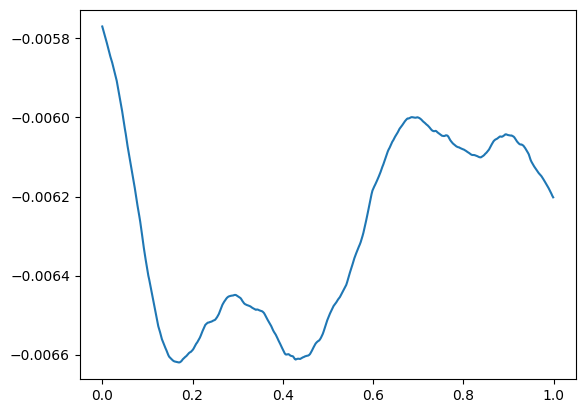

  1%|          | 100/10000 [00:01<02:37, 62.74it/s]

Epoch 100 | Loss: 0.9419078826904297


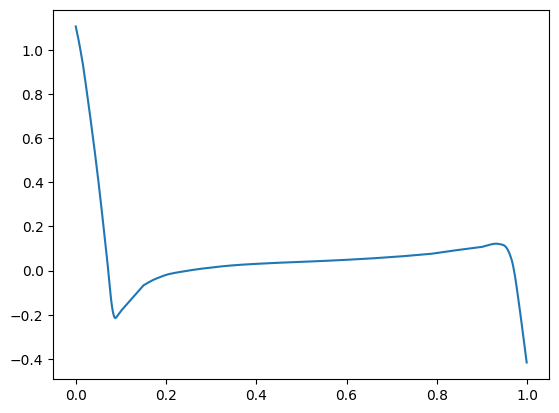

  2%|▏         | 198/10000 [00:03<02:38, 61.70it/s]

Epoch 200 | Loss: 0.8554052114486694


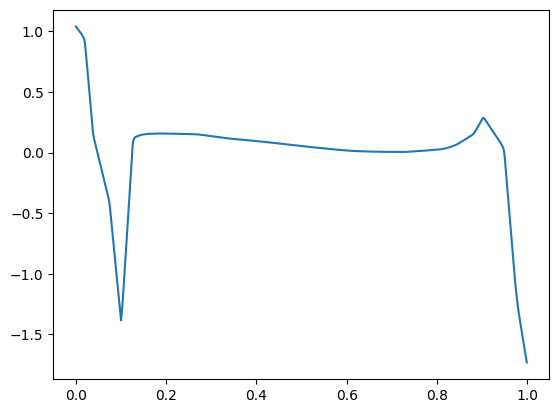

  3%|▎         | 299/10000 [00:05<02:37, 61.78it/s]

Epoch 300 | Loss: 0.9564966559410095


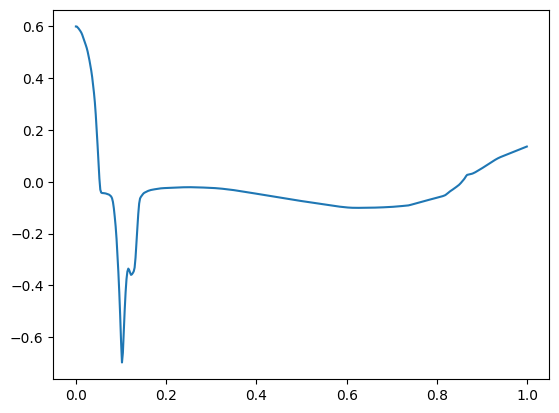

  4%|▍         | 398/10000 [00:06<02:35, 61.78it/s]

Epoch 400 | Loss: 0.7666871547698975


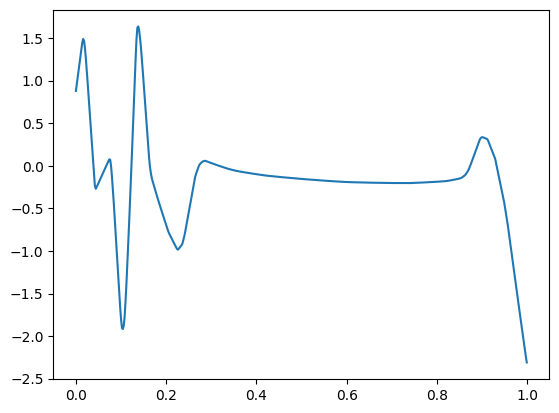

  5%|▍         | 499/10000 [00:08<02:35, 61.18it/s]

Epoch 500 | Loss: 0.6361037492752075


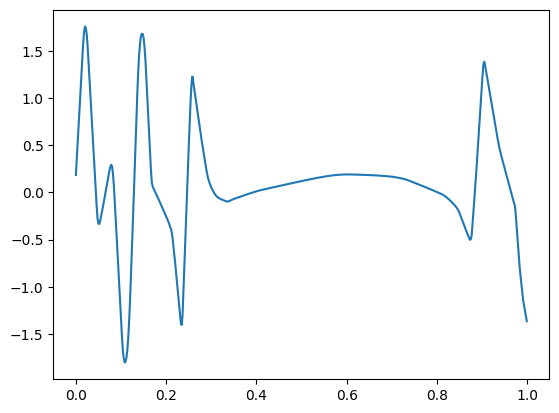

  6%|▌         | 598/10000 [00:10<02:33, 61.22it/s]

Epoch 600 | Loss: 0.5716002583503723


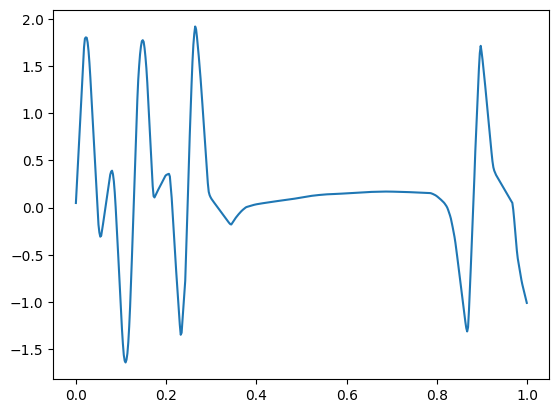

  7%|▋         | 698/10000 [00:12<02:32, 61.06it/s]

Epoch 700 | Loss: 0.5137938261032104


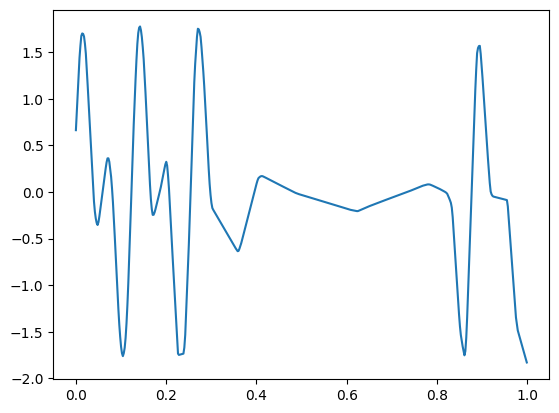

  8%|▊         | 798/10000 [00:13<02:31, 60.61it/s]

Epoch 800 | Loss: 0.4584200382232666


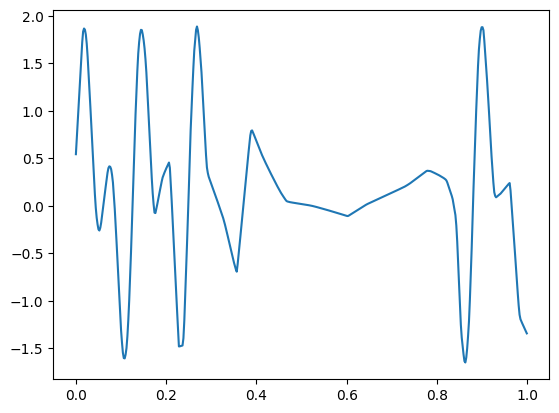

  9%|▉         | 898/10000 [00:15<02:30, 60.66it/s]

Epoch 900 | Loss: 0.4094489812850952


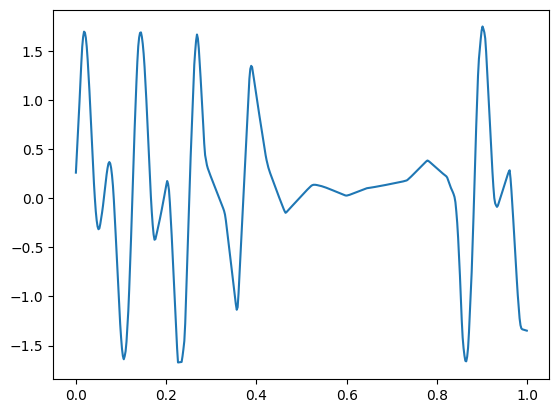

 10%|▉         | 998/10000 [00:17<02:28, 60.69it/s]

Epoch 1000 | Loss: 0.3755154311656952


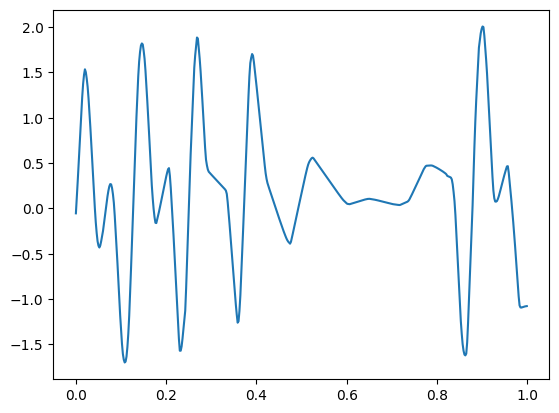

 11%|█         | 1098/10000 [00:19<02:26, 60.57it/s]

Epoch 1100 | Loss: 0.2731744647026062


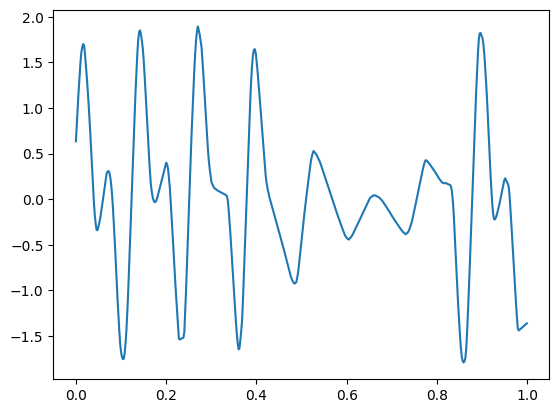

 12%|█▏        | 1198/10000 [00:21<02:26, 60.23it/s]

Epoch 1200 | Loss: 0.14619134366512299


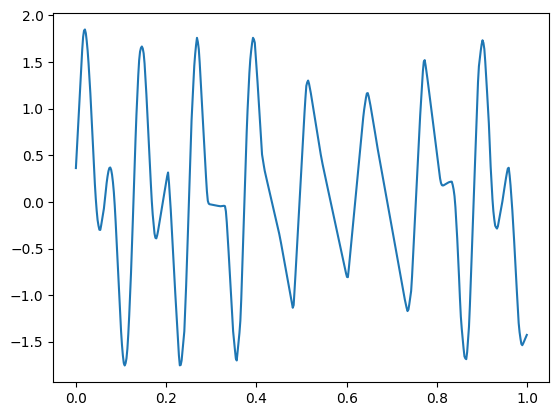

 13%|█▎        | 1298/10000 [00:23<02:24, 60.33it/s]

Epoch 1300 | Loss: 0.09115597605705261


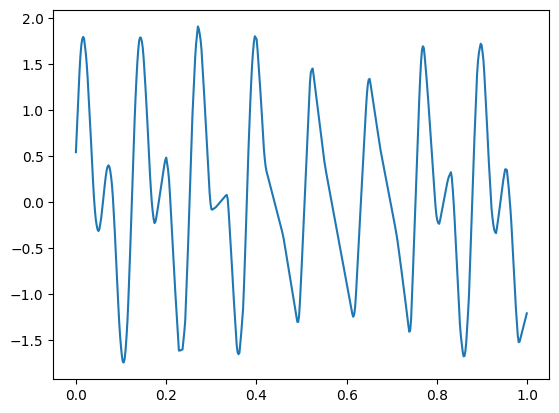

 14%|█▍        | 1398/10000 [00:24<02:22, 60.16it/s]

Epoch 1400 | Loss: 0.09352514892816544


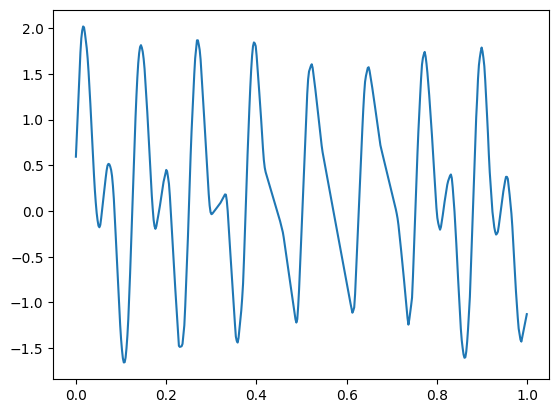

 15%|█▍        | 1498/10000 [00:26<02:21, 60.02it/s]

Epoch 1500 | Loss: 0.04571528732776642


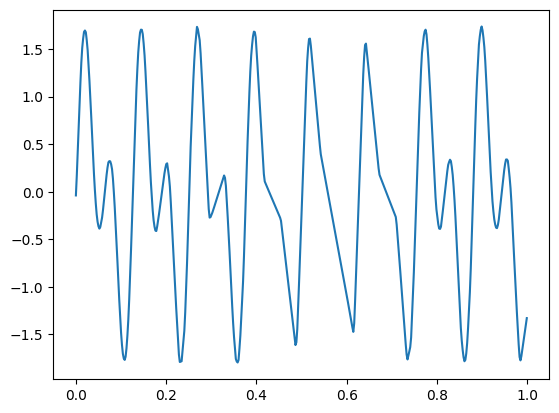

 16%|█▌        | 1598/10000 [00:28<02:19, 60.13it/s]

Epoch 1600 | Loss: 0.03336618095636368


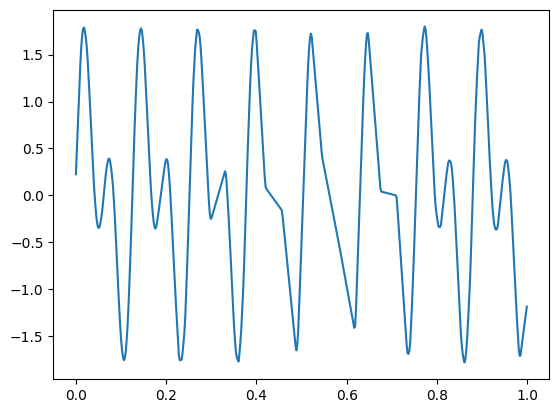

 17%|█▋        | 1698/10000 [00:30<02:18, 60.06it/s]

Epoch 1700 | Loss: 0.026890436187386513


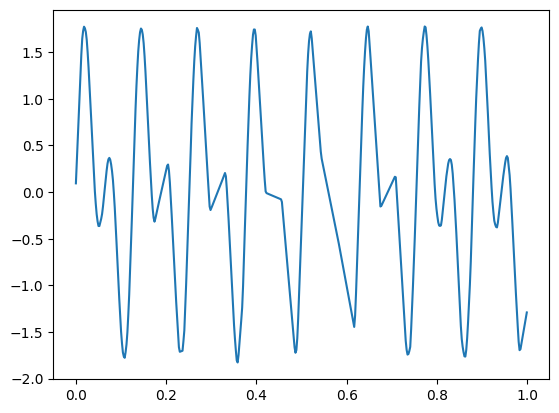

 18%|█▊        | 1798/10000 [00:32<02:18, 59.32it/s]

Epoch 1800 | Loss: 0.02919805608689785


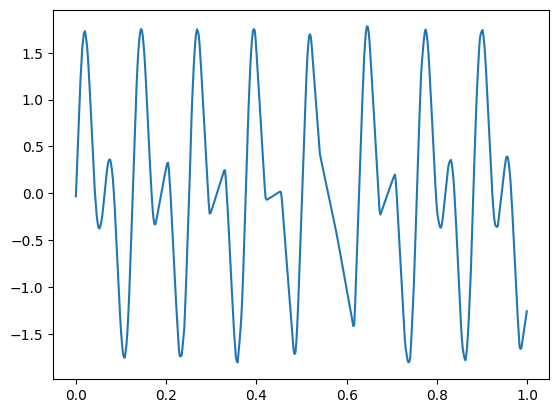

 19%|█▉        | 1898/10000 [00:34<02:16, 59.49it/s]

Epoch 1900 | Loss: 0.06279731541872025


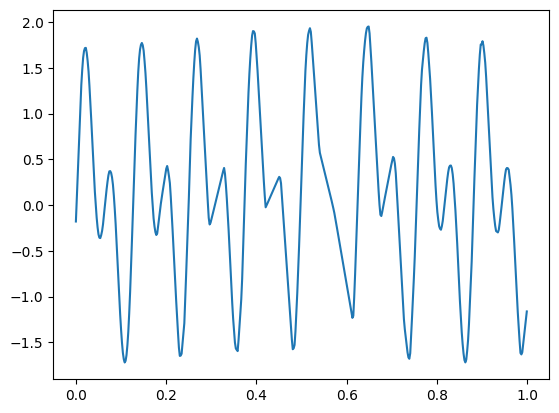

 20%|█▉        | 1998/10000 [00:35<02:14, 59.65it/s]

Epoch 2000 | Loss: 0.10513344407081604


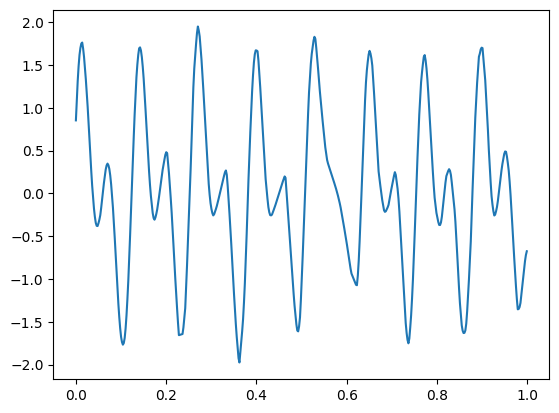

 21%|██        | 2098/10000 [00:37<02:12, 59.46it/s]

Epoch 2100 | Loss: 0.015710890293121338


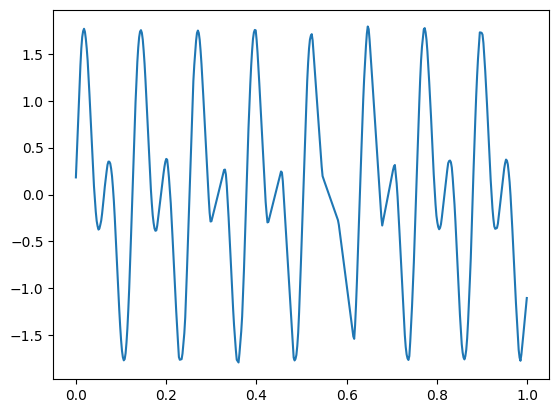

 22%|██▏       | 2198/10000 [00:39<02:09, 60.22it/s]

Epoch 2200 | Loss: 0.010539962910115719


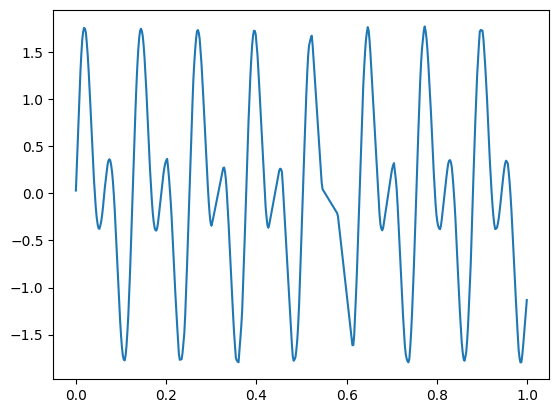

 23%|██▎       | 2298/10000 [00:41<02:09, 59.49it/s]

Epoch 2300 | Loss: 0.02094178833067417


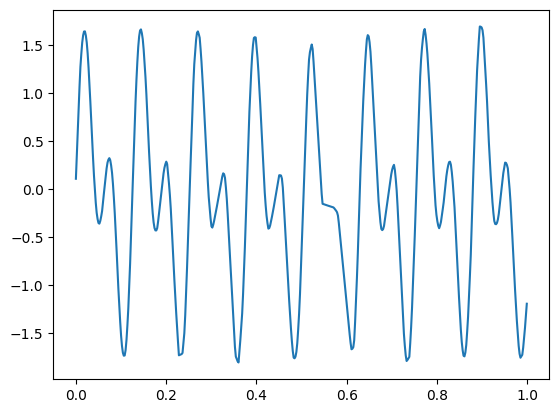

 24%|██▍       | 2397/10000 [00:43<02:08, 59.39it/s]

Epoch 2400 | Loss: 0.007035962305963039


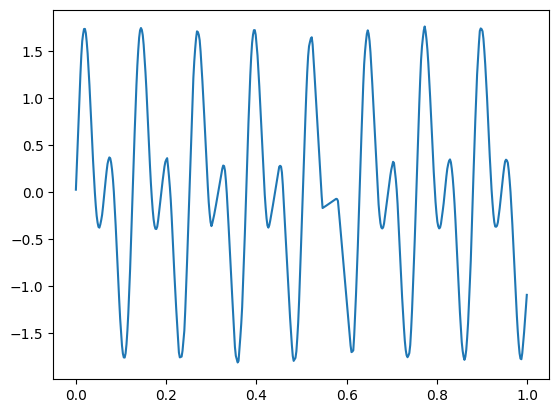

 25%|██▍       | 2497/10000 [00:45<02:07, 58.85it/s]

Epoch 2500 | Loss: 0.010592806152999401


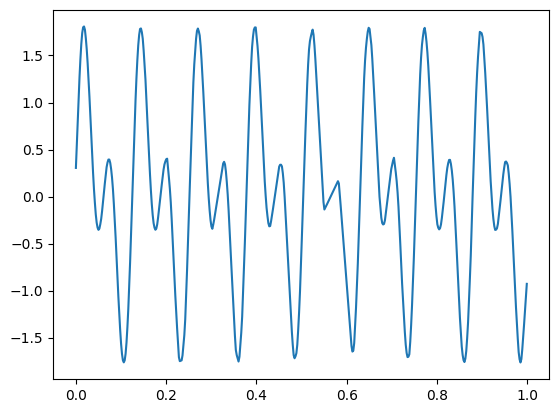

 26%|██▌       | 2597/10000 [00:47<02:07, 58.25it/s]

Epoch 2600 | Loss: 0.004887161310762167


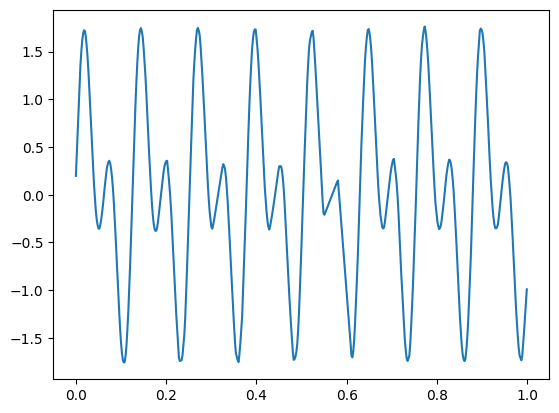

 27%|██▋       | 2698/10000 [00:48<02:03, 59.09it/s]

Epoch 2700 | Loss: 0.003564215265214443


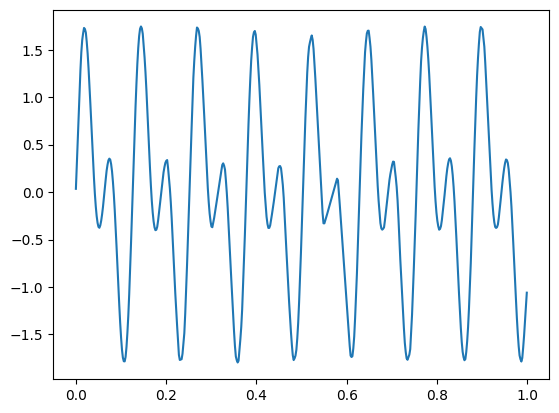

 28%|██▊       | 2798/10000 [00:50<02:02, 58.96it/s]

Epoch 2800 | Loss: 0.0138121098279953


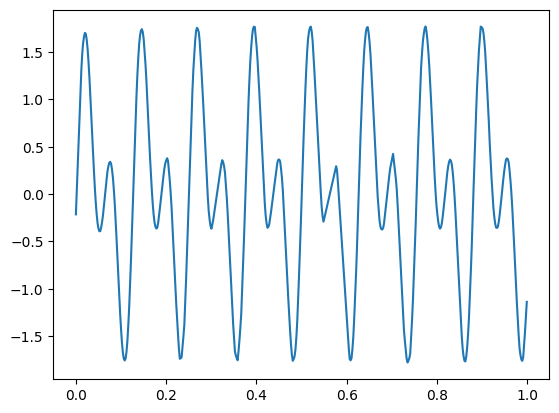

 29%|██▉       | 2898/10000 [00:52<01:59, 59.25it/s]

Epoch 2900 | Loss: 0.010719001293182373


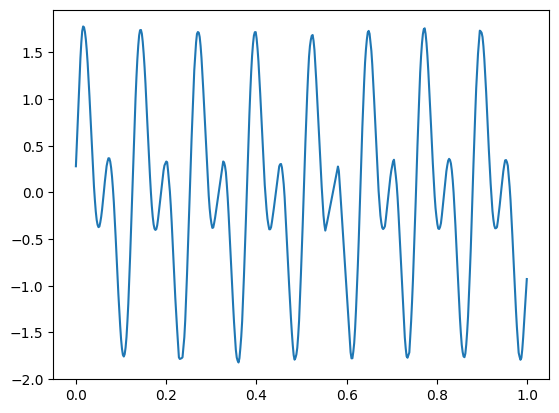

 30%|██▉       | 2998/10000 [00:54<01:58, 59.20it/s]

Epoch 3000 | Loss: 0.006698003038764


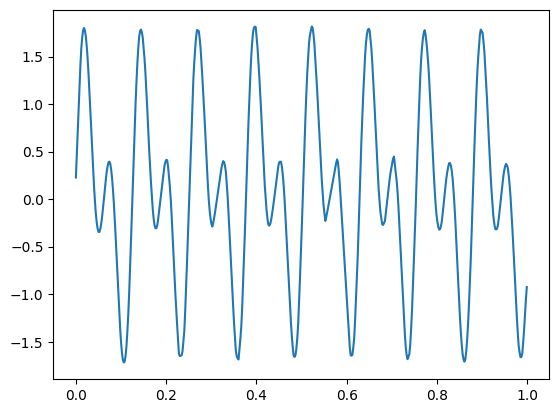

 31%|███       | 3097/10000 [00:56<01:56, 59.46it/s]

Epoch 3100 | Loss: 0.00574029516428709


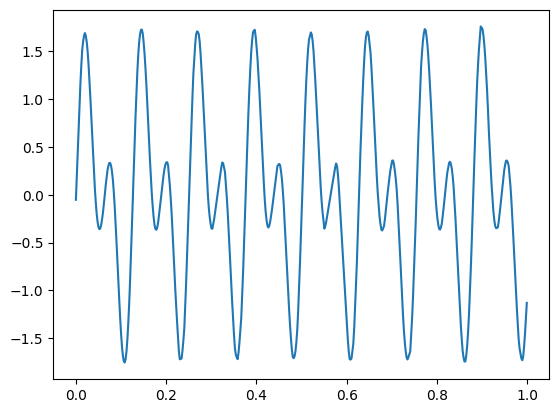

 32%|███▏      | 3200/10000 [00:58<01:54, 59.24it/s]

Epoch 3200 | Loss: 0.006976364646106958


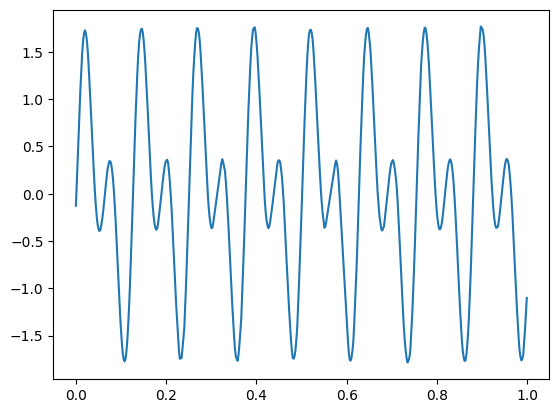

 33%|███▎      | 3298/10000 [00:59<01:52, 59.83it/s]

Epoch 3300 | Loss: 0.0008058408857323229


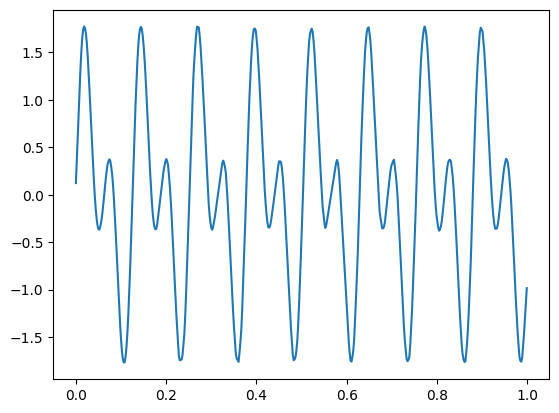

 34%|███▎      | 3366/10000 [01:01<02:00, 54.95it/s]


KeyboardInterrupt: 

In [ ]:
for epoch in tqdm(range(epochs)):
  model.train()
  optimizer.zero_grad()

  pred = model(train_data[0])
  model_loss = loss(pred, train_data[1])

  model_loss.backward()
  optimizer.step()

  if (epoch % 100) == 0:
    print(f'Epoch {epoch} | Loss: {model_loss}')
    plt.plot(train_data[0].cpu(), pred.detach().cpu())
    plt.show()

model.eval()
model.cpu()

plt.plot(X_test, model(X_test).detach().numpy())
plt.plot(train_data[0].cpu(), train_data[1].cpu(), '.')
plt.show()

## hash net

In [ ]:
# import tinycudann as tcnn

# adapted from https://github.com/nerfstudio-project/nerfstudio/blob/main/nerfstudio/field_components/encodings.py#L310
class HashLayer(nn.Module):
  def __init__(self,
               input_dim: int,
               num_levels: int = 16,
               min_res: int = 16,
               max_res: int = 1024,
               log2_hashmap_size: int = 8,
               features_per_level: int = 2,
               hash_init_scale: float = 0.001,
               primes: Optional[Sequence[int]] = [97],
               implementation: Literal["tcnn", "torch"] = "tcnn",
               interpolation: Optional[Literal["Nearest", "Linear", "Smoothstep"]] = None,
  ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.num_levels = num_levels
        self.min_res = min_res
        self.features_per_level = features_per_level
        self.hash_init_scale = hash_init_scale
        self.log2_hashmap_size = log2_hashmap_size
        self.hash_table_size = 2**log2_hashmap_size
        self.primes = torch.tensor(primes)

        levels = torch.arange(num_levels)
        self.growth_factor = np.exp((np.log(max_res) - np.log(min_res)) / (num_levels - 1)) if num_levels > 1 else 1
        self.resolutions = torch.floor(min_res * self.growth_factor**levels)

        self.hash_offset = levels * self.hash_table_size

        self.tcnn_encoding = None
        self.hash_table = torch.empty(0)

        if implementation == "torch":
          self.build_hash_table()
        elif implementation == "tcnn":
          encoding_config = self.get_tcnn_encoding_config(
              num_levels=self.num_levels,
              features_per_level=self.features_per_level,
              log2_hashmap_size=self.log2_hashmap_size,
              min_res=self.min_res,
              growth_factor=self.growth_factor,
              interpolation=interpolation,
          )
          self.tcnn_encoding = tcnn.Encoding(
              n_input_dims=input_dim,
              encoding_config=encoding_config,
          )

        if self.tcnn_encoding is None:
            assert (
                interpolation is None or interpolation == "Linear"
            ), f"interpolation '{interpolation}' is not supported for torch encoding backend"

  @classmethod
  def get_tcnn_encoding_config(
      cls, num_levels, features_per_level, log2_hashmap_size, min_res, growth_factor, interpolation=None
  ) -> dict:
      """Get the encoding configuration for tcnn if implemented"""
      encoding_config = {
          "otype": "HashGrid",
          "n_levels": num_levels,
          "n_features_per_level": features_per_level,
          "log2_hashmap_size": log2_hashmap_size,
          "base_resolution": min_res,
          "per_level_scale": growth_factor,
      }
      if interpolation is not None:
          encoding_config["interpolation"] = interpolation
      return encoding_config

  def get_out_dim(self) -> int:
      return self.num_levels * self.features_per_level

  def build_hash_table(self):
      self.hash_table = torch.rand(size=(self.hash_table_size * self.num_levels, self.features_per_level)) * 2 - 1
      self.hash_table *= self.hash_init_scale
      self.hash_table = nn.Parameter(self.hash_table)

  def hash_fn(self, in_tensor):
    assert self.input_dim == len(self.primes), 'Input dimension must match number of primes'

    if self.input_dim == 1:
      return ((in_tensor.squeeze() * self.primes[0]) % self.hash_table_size) + self.hash_offset

    in_tensor = in_tensor * self.primes.to(in_tensor.device)
    x = torch.bitwise_xor(in_tensor[:, 0], in_tensor[:, 1])
    for d in range(self.input_dim - 2):
      x = torch.bitwise_xor(x, in_tensor[:, d + 2])
    return (x % self.hash_table_size) + self.hash_offset

  def torch_forward(self, x):
    if x.dim() == 1:
      x = x.unsqueeze(-1)

    x_proj = x[..., None, :self.input_dim] # (..., 1, D)
    x_scaled = x_proj * self.resolutions.view(-1, 1).to(x.device) # (..., L, D)
    scaled_c = torch.ceil(x_scaled).type(torch.int32)
    scaled_f = torch.floor(x_scaled).type(torch.int32)

    offsets = x_scaled - scaled_f # (..., L, D)

    if self.input_dim == 1:
      hashed_0 = self.hash_fn(scaled_c) # (..., L)
      hashed_1 = self.hash_fn(scaled_f)
      features_0 = self.hash_table[hashed_0] # (..., L, F)
      features_1 = self.hash_table[hashed_1]
      encoded = (features_0 * (1 - offsets) + features_1 * offsets) # (..., L, F)
      return torch.flatten(encoded, start_dim=-2) # (..., L*F)
    elif self.input_dim == 2:
      hashed_0 = self.hash_fn(scaled_c)
      hashed_1 = self.hash_fn(torch.cat([scaled_f[..., 0:1], scaled_c[..., 1:2]], dim=-1))  # Bottom-right
      hashed_2 = self.hash_fn(scaled_f)
      hashed_3 = self.hash_fn(torch.cat([scaled_c[..., 0:1], scaled_f[..., 1:2]], dim=-1))  # Top-left

      f_0 = self.hash_table[hashed_0] # (..., L, F)
      f_1 = self.hash_table[hashed_1]
      f_2 = self.hash_table[hashed_2]
      f_3 = self.hash_table[hashed_3]

      f_01 = (f_0 * (1 - offsets[..., 0:1]) + f_1 * offsets[..., 0:1]) # (..., L, F)
      f_23 = (f_2 * (1 - offsets[..., 0:1]) + f_3 * offsets[..., 0:1])

      encoded = (f_01 * (1 - offsets[..., 1:2]) + f_23 * offsets[..., 1:2])
      return torch.flatten(encoded, start_dim=-2) # (..., L*F)

  def forward(self, in_tensor):
    if self.tcnn_encoding is not None:
      return self.tcnn_encoding(in_tensor)
    return self.torch_forward(in_tensor)

def spatial_hash_1d(x, prime, T):
  return (x * prime) % T
  # try torch remainder?

class HashLayer1D(nn.Module):
  def __init__(self, levels, dim_features, N_min=2, N_max=2**8, prime=937, T=2**8):
    super().__init__()
    self.levels = levels
    self.dim_features = dim_features
    self.N_min = N_min
    self.N_max = N_max
    self.prime = prime
    self.T = T # size of hash table
    # self.features = nn.Parameter(torch.randn(levels, T, dim_features)) # (L, T, F)
    self.features = nn.ParameterList(
        [ nn.Parameter(torch.rand(T, dim_features)) for i in range(levels)]
    )
    self.b = np.exp((np.log(N_max) - np.log(N_min))/(levels-1))
    self.N = torch.tensor(
        [N_min * self.b**i for i in range(levels)], device=device) # (L)

  def forward(self, x):
    assert x.dim() <= 2, 'Input must be 1D or batched 1D'
    if x.dim() == 1:
      x = x.unsqueeze(-1)

    x_proj = x[:, 0].unsqueeze(-1) # (B, 1)
    x_scaled_N = x_proj * self.N # (B, L)
    x_rounded = [torch.floor(x_scaled_N).long(), torch.ceil(x_scaled_N).long()]
    idx_lower = spatial_hash_1d(x_rounded[0], self.prime, self.T) # (B, L)
    idx_upper = spatial_hash_1d(x_rounded[1], self.prime, self.T)
    out = []
    for i in range(self.levels):
      out.append(0.5 * (torch.gather(self.features[i], 0, idx_lower[:,i].unsqueeze(-1).expand(-1, self.dim_features)) +
                        torch.gather(self.features[i], 0, idx_upper[:,i].unsqueeze(-1).expand(-1, self.dim_features))))
    return torch.cat(out, dim=-1) #(B, L*F)
    # return torch.cat([0.5*(self.features[i][idx_lower[:,i]] +
    #                   self.features[i][idx_upper[:,i]])
    #                   for i in range(self.levels)], dim=-1) #(B, L*F)

In [ ]:
class HashNet(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims,
               activation=nn.ReLU()):
    super().__init__()
    layers = []

    curr_dim = input_dim
    fc, hash = 0, 0
    for dim in hidden_dims:
      if type(dim) == int:
        layers.append((f'fc_{fc}', nn.Linear(curr_dim, dim)))
        layers.append((f'act_{fc}', activation))
        curr_dim = dim
        fc += 1
      elif type(dim) == str:
        L, F, N_max, *_ = [int(p) for p in dim[1:].split(',')]
        layers.append((f'hash_{hash}',
                       HashLayer(input_dim=1,
                                num_levels=L,
                                features_per_level=F,
                                max_res=N_max,
                                log2_hashmap_size=10,
                                implementation='torch')))
        # layers.append(HashLayer1D(levels=L,
        #                           dim_features=F,
        #                           N_max=N_max,
        #                           T=64))
        curr_dim = L*F
        hash += 1

    final_linear = ('output_layer', nn.Linear(curr_dim, output_dim))
    layers.append(final_linear)

    self.net = nn.Sequential(OrderedDict(layers))
    self.apply(self.kaiming_init)

  def kaiming_init(self, module):
    if isinstance(module, nn.Linear):
      nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
      if module.bias is not None:
        nn.init.zeros_(module.bias)

  def forward(self, x):
      return self.net(x)

In [ ]:
a,b,c,*_ = [int(p) for p in '#16,2,64'[1:].split(',')]
b

2

In [ ]:
print(model)
print(np.sum([p.numel() for p in model.parameters()]))

HashNet(
  (net): Sequential(
    (fc_0): Linear(in_features=1, out_features=64, bias=True)
    (act_0): ReLU()
    (fc_1): Linear(in_features=64, out_features=256, bias=True)
    (act_1): ReLU()
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)
17025


In [ ]:
model = HashNet(input_dim=1, output_dim=1, hidden_dims=['#16, 2, 256', 256]) # L, F, N_max
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()


# plt.imshow(model.net[2].features[0].detach().numpy())
model = model.to(device)

activations, gradients = {}, {}
def save_activation(name):
  def hook(model, input, output):
    activations[name] = output.detach().cpu()
  return hook

def save_gradients(name):
  def hook(model, grad_in, grad_out):
    gradients[name] = grad_out[0].detach().cpu()
  return hook

for name, layer in model.net.named_modules():
  if type(layer) == nn.Linear or type(layer) == HashLayer:
    layer.register_forward_hook(save_activation(name))
    layer.register_full_backward_hook(save_gradients(name))
# [d.to(device) for d in train_data]

# for layer in model.net[1:]:
#   for param in layer.parameters():
#     param.requires_grad = False

Epoch 0 | Loss: 2.140998363494873
Epoch 100 | Loss: 0.494509756565094
Epoch 200 | Loss: 0.4872860014438629
Epoch 300 | Loss: 0.48580053448677063
Epoch 400 | Loss: 0.4856720268726349


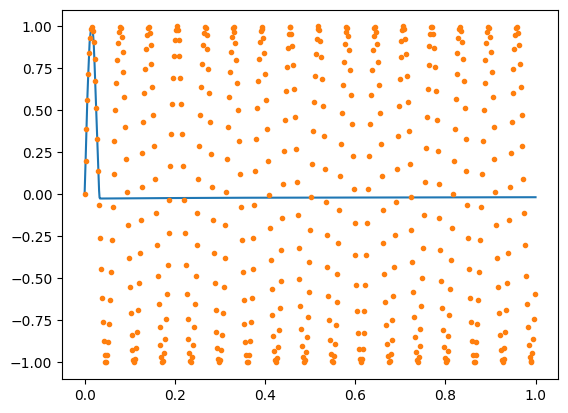

In [ ]:
feature_map_grads = []
linear_grad = []

epochs = 500

for epoch in range(epochs):
  model.train()
  optimizer.zero_grad()

  pred = model(train_data[0])
  model_loss = loss(pred, train_data[1])

  model_loss.backward()
  optimizer.step()

  with torch.no_grad():
    # for param in model.net[2].features.parameters():
    #   if param.grad is not None:
    #     feature_map_grads.append(param.grad.norm().item())
    # if model.net[0].weight.grad is not None:
    #   linear_grad.append(model.net[1].weight.norm().item())

    if (epoch % 100) == 0:
        print(f'Epoch {epoch} | Loss: {model_loss}')


model.eval()

plt.plot(X_test, model(X_test.to(device)).cpu().detach().numpy())
plt.plot(train_data[0].cpu(), train_data[1].cpu(), '.')
plt.show()
# plt.imshow(model.net[2].features[0].detach().cpu().numpy())


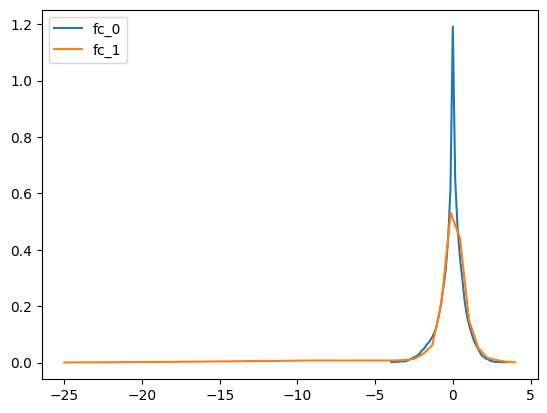

In [ ]:
for (layer, activation) in activations.items():
  if layer == 'output_layer':
    continue
  hist, bins = np.histogram(activation.ravel(), bins=50, density=True)
  bin_centers = (bins[:-1]  + bins[1:]) / 2
  plt.plot(bin_centers, hist, label=layer)
plt.legend()
plt.show()


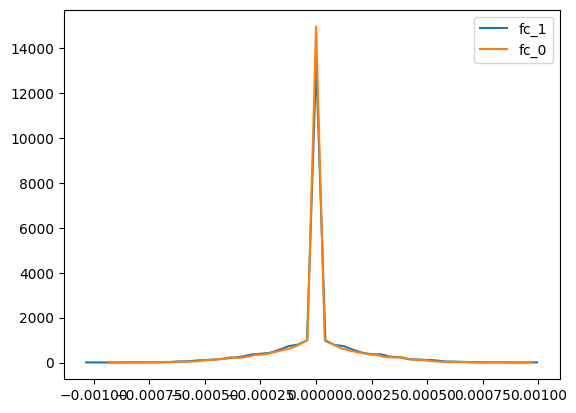

In [ ]:
for (layer, gradient) in gradients.items():
  if layer == 'output_layer':
    continue
  hist, bins = np.histogram(gradient.ravel(), bins=50, density=True)
  bin_centers = (bins[:-1]  + bins[1:]) / 2plot(bin_centers, hist, label=layer)
plt.legend()
plt.show()


## beam network definitions
name is wip

In [179]:
import torch.nn.functional as F
# adapted from https://github.com/nerfstudio-project/nerfstudio/blob/main/nerfstudio/field_components/encodings.py#L310
class BeamLayer(nn.Module):
  def __init__(self,
               input_dim: int,
               num_levels: int = 16,
               min_res: int = 16,
               max_res: int = 1024,
               features_per_level: int = 2,
               init_scale: float = 0.001,
               interpolation: Optional[Literal["nearest", "bilinear", "bicubic"]] = None,
  ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.num_levels = num_levels
        self.min_res = min_res
        self.max_res = max_res
        self.features_per_level = features_per_level
        self.init_scale = init_scale

        levels = np.arange(num_levels)
        self.growth_factor = np.exp((np.log(max_res) - np.log(min_res)) / (num_levels - 1)) if num_levels > 1 else 1
        self.resolutions = np.floor(min_res * self.growth_factor**levels).astype(int)
        self.build_lookup()

  def build_lookup(self):
      # self.feature_grid = torch.rand(
          # size=(self.features_per_level, self.max_res, self.max_res))
      self.feature_grid = nn.ParameterList(
        [ nn.Parameter(torch.randn(self.features_per_level, res, res, device=device))
        for res in self.resolutions]) # [L, F, N, N]
      # self.feature_grid *= self.init_scale
      # self.feature_grid = nn.Parameter(self.feature_grid)

  def forward(self, x):
    if x.dim() == 1:
      x = x.unsqueeze(-1)
    mins, _ = x.min(dim=0, keepdim=True)
    maxs, _ = x.max(dim=0, keepdim=True)
    # print('mins', mins[0], 'maxs', maxs[0])
    x_normalized = 2 * ( x - mins )
    # print(x_normalized[0])
    x_normalized = x_normalized / (maxs - mins) - 1
    # print(x_normalized[0])
    # x_normalized = torch.clamp(x, -1, 1)
    # x_normalized = x
    # print(x_normalized.shape)
    x_proj = x_normalized[None, :, None, :2] # (1, B, 1, 2)
    # print(x_proj.shape)
    x_interpolated = torch.zeros(self.num_levels,
                                 self.features_per_level,
                                 x.shape[0], device=device) # (L, F, B)
    for l in range(self.num_levels):
      x_interpolated[l] = F.grid_sample(self.feature_grid[l].unsqueeze(0),
                                        x_proj,
                                        mode='bilinear',
                                        align_corners=True).squeeze()
                                        # (1, F, B, 1) -> (F, B)

    return torch.flatten(x_interpolated, start_dim=0, end_dim=1).transpose(0, 1) # [B, F]

class BeamLayerGrad(torch.autograd.Function):
  """
    Autograd function implementing numerical gradient calculation for beam layer
  """

  @staticmethod
  def forward(ctx, x, feature_grid):
    pass
  @staticmethod
  def backward(ctx, grad_output):
    pass

class BeamNet(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims,
               final_linear: bool = True,
               sigmoid_output: bool = False,
               activation=nn.ReLU()):
    super().__init__()
    layers = []

    curr_dim = input_dim
    fc, beam = 0, 0
    for dim in hidden_dims:
      if type(dim) == int:
        layers.append((f'fc_{fc}', nn.Linear(curr_dim, dim)))
        layers.append((f'act_{fc}', activation))
        curr_dim = dim
        fc += 1
      elif type(dim) == str:
        L, F, N_max, *_ = [int(p) for p in dim[1:].split(',')]
        layers.append((f'beam_{beam}',
                       BeamLayer(input_dim=2,
                                num_levels=L,
                                features_per_level=F,
                                max_res=N_max)))
        curr_dim = L*F
        beam += 1
    if final_linear:
      final_linear = ('fc_final', nn.Linear(curr_dim, output_dim))
      layers.append(final_linear)

    if sigmoid_output:
      layers.append(('sigmoid_out', nn.Sigmoid()))

    self.net = nn.Sequential(OrderedDict(layers))
    self.apply(self.kaiming_init)

  def kaiming_init(self, module):
    if isinstance(module, nn.Linear):
      nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
      if module.bias is not None:
        nn.init.zeros_(module.bias)

  def zero_init(self, module):
    if isinstance(module, nn.Linear):
      nn.init.zeros_(module.weight)
      if module.bias is not None:
        nn.init.zeros_(module.bias)

  def forward(self, x):
      return self.net(x)

In [83]:
# tensorboard helper functions

def plot_pred(net, x):
  pred = net(x)
  fig = plt.figure(figsize=(12,10))
  plt.plot(x.cpu(), pred.cpu().detach().numpy())
  return fig

def plot_gradient_flow(named_parameters):
  ave_grads = []
  layers = []
  for n, p in named_parameters:
      if(p.requires_grad) and ("bias" not in n):
          layers.append(n)
          ave_grads.append(p.grad.abs().mean().cpu())
  plt.plot(ave_grads, color="b", linewidth=3, alpha=0.3)
  plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
  plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
  plt.xlim(xmin=0, xmax=len(ave_grads))
  plt.xlabel("Layers")
  plt.ylabel("average gradient")
  plt.title("Gradient flow")
  plt.grid(True)
  # return fig

## test/1D function fitting

In [90]:
model = BeamNet(input_dim=2, output_dim=1,
                hidden_dims=['#16,16,256', 256],
                activation=nn.ReLU()) # L, F, N_max
# model = BeamNet(input_dim=1, output_dim=1, hidden_dims=[256, 256]*4) # L, F, N_max

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = nn.MSELoss()

# plt.imshow(model.net[2].features[0].detach().numpy())

activations, gradients = {}, {}
def save_activation(name):
  def hook(model, input, output):
    activations[name] = output.detach().cpu()
  return hook

def save_gradients(name):
  def hook(model, grad_in, grad_out):
    gradients[name] = grad_out[0].mean().detach().cpu()
  return hook

for name, layer in model.net.named_modules():
  if type(layer) == nn.Linear or type(layer) == BeamLayer:
    layer.register_forward_hook(save_activation(name))
    layer.register_full_backward_hook(save_gradients(name))

In [85]:
print(model)
np.sum([p.numel() for p in model.parameters()])

BeamNet(
  (net): Sequential(
    (beam_0): BeamLayer(
      (feature_grid): ParameterList(
          (0): Parameter containing: [torch.float32 of size 16x16x16 (cuda:0)]
          (1): Parameter containing: [torch.float32 of size 16x19x19 (cuda:0)]
          (2): Parameter containing: [torch.float32 of size 16x23x23 (cuda:0)]
          (3): Parameter containing: [torch.float32 of size 16x27x27 (cuda:0)]
          (4): Parameter containing: [torch.float32 of size 16x33x33 (cuda:0)]
          (5): Parameter containing: [torch.float32 of size 16x40x40 (cuda:0)]
          (6): Parameter containing: [torch.float32 of size 16x48x48 (cuda:0)]
          (7): Parameter containing: [torch.float32 of size 16x58x58 (cuda:0)]
          (8): Parameter containing: [torch.float32 of size 16x70x70 (cuda:0)]
          (9): Parameter containing: [torch.float32 of size 16x84x84 (cuda:0)]
          (10): Parameter containing: [torch.float32 of size 16x101x101 (cuda:0)]
          (11): Parameter containing

3423281

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Loss: 0.8901357650756836


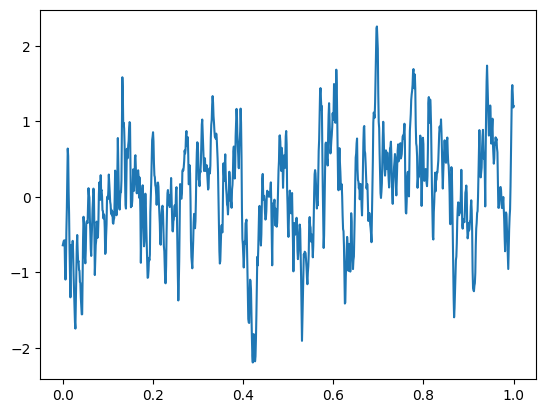

 18%|█▊        | 88/500 [00:00<00:03, 132.62it/s]

Epoch 100 | Loss: 0.01927695982158184


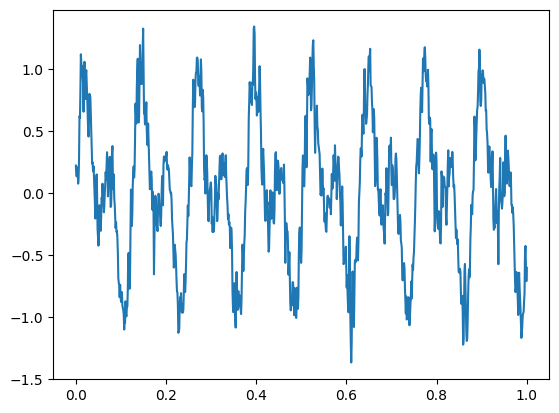

 38%|███▊      | 189/500 [00:01<00:02, 131.38it/s]

Epoch 200 | Loss: 0.0037463714834302664


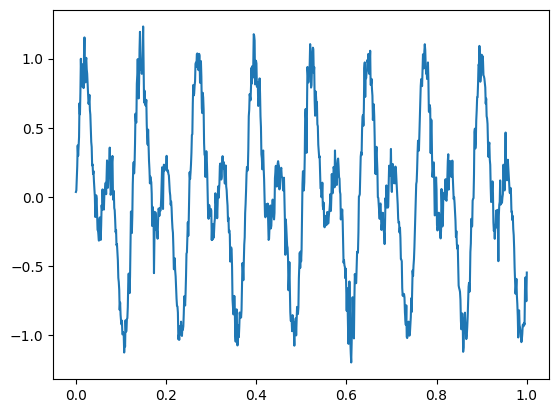

 58%|█████▊    | 289/500 [00:02<00:01, 130.01it/s]

Epoch 300 | Loss: 0.0010296704713255167


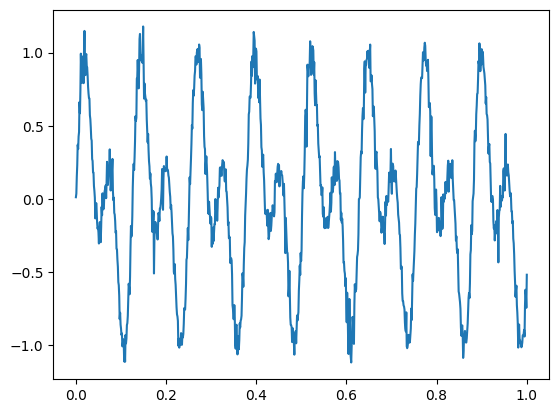

 78%|███████▊  | 391/500 [00:03<00:00, 126.78it/s]

Epoch 400 | Loss: 0.00029696241836063564


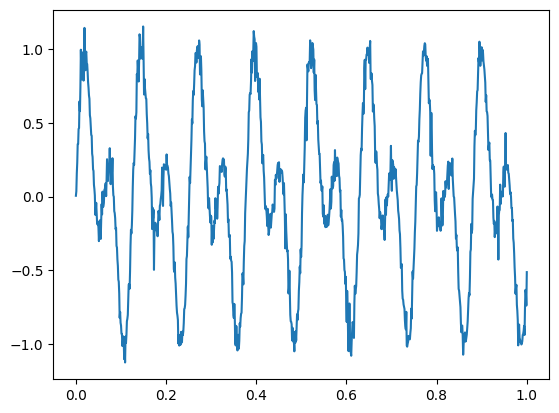

100%|██████████| 500/500 [00:04<00:00, 101.59it/s]


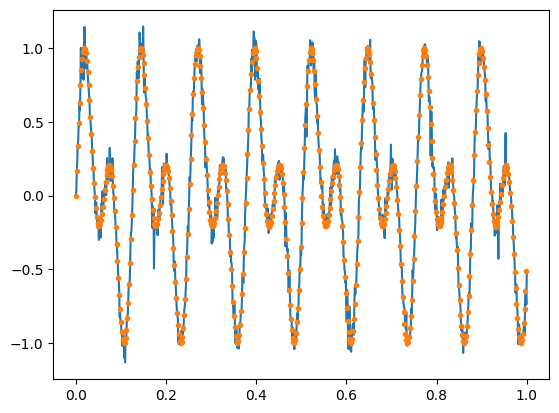

In [91]:
feature_map_grads = []
linear_grad = []

epochs = 500
model = model.to(train_data[0])

X_test_2d = X_test.repeat(1, 2).to(device)
X_test = X_test.cpu()
X_train = train_data[0].repeat(1, 2).to(device)

# plt.ion()
# pred_fig, pred_ax = plt.subplots()
# pred_line, = pred_ax.plot(train_data[0].cpu(), np.zeros_like(train_data[0].cpu()))
# pred_ax.set_title(f'Epoch 0')

for epoch in tqdm(range(epochs)):
  model.train()
  optimizer.zero_grad()

  pred = model(X_train)
  model_loss = loss(pred, train_data[1])
  writer.add_scalar('Loss/train', model_loss, epoch)

  model_loss.backward()
  optimizer.step()

  with torch.no_grad():
    if (epoch % 100) == 0:
        print(f'Epoch {epoch} | Loss: {model_loss}')
        plt.plot(X_test, model(X_test_2d).cpu().detach().numpy())
        plt.show()

        # writer.add_figure('Gradient flow',
        # writer.add_figure('Prediction', plot_pred(model, X_test), global_step=epoch)
        # plot_gradient_flow(model.named_parameters())
        # pred_line.set_ydata(pred.detach().cpu())
        # pred_ax.set_title(f'Epoch {epoch}')
        # pred_fig.canvas.draw()
        # pred_fig.canvas.flush_events()
        # writer.add_figure('Gradient flow', plot_gradient_flow(model.named_parameters()))

plt.ioff()
plt.show()
model.eval()

writer.flush()
plt.plot(X_test, model(X_test_2d).cpu().detach().numpy())
plt.plot(train_data[0].cpu(), train_data[1].cpu(), '.')
plt.show()


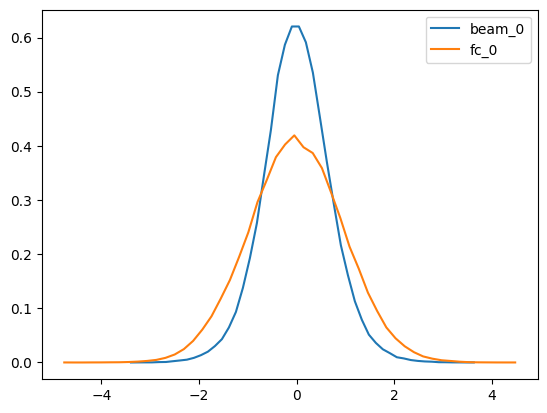

In [97]:
for (layer, activation) in activations.items():
  if layer == 'output_layer':
    continue
  hist, bins = np.histogram(activation.ravel(), bins=50, density=True)
  bin_centers = (bins[:-1]  + bins[1:]) / 2
  plt.plot(bin_centers, hist, label=layer)
plt.legend()
plt.show()

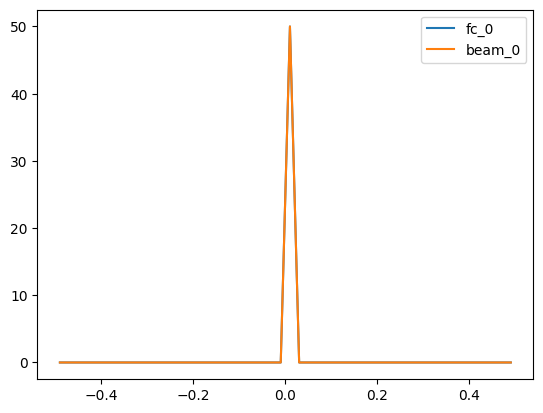

In [96]:
for (layer, gradient) in gradients.items():
  if layer == 'output_layer':
    continue
  hist, bins = np.histogram(gradient.ravel(), bins=50, density=True)
  bin_centers = (bins[:-1]  + bins[1:]) / 2
  plt.plot(bin_centers, hist, label=layer)
plt.legend()
plt.show()


# test/2D single image overfitting

<ipython-input-156-daa00277e55f>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3]


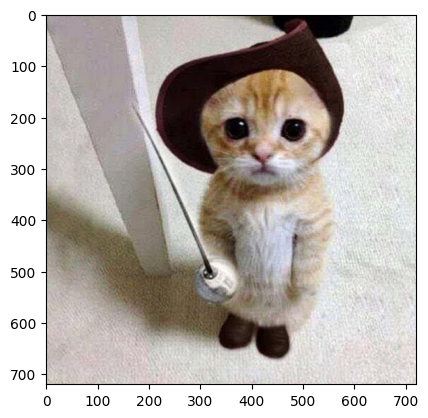

(720, 720, 3)


In [156]:
# Download image, take a square crop from the center
import imageio

image_url = 'https://i.ytimg.com/vi/SQJrYw1QvSQ/maxresdefault.jpg'
img = imageio.imread(image_url)[..., :3]
h, w = img.shape[:2]
crop = min(h, w)
top = (h - crop) // 2
left = (w - crop) // 2
bottom = top + crop
right = left + crop
img = img[top:bottom, left:right] / 255.0
plt.imshow(img)
plt.show()
print(img.shape)

torch.Size([518400, 2])
torch.Size([720, 720, 3])
torch.Size([129600, 2])
torch.Size([129600, 3])


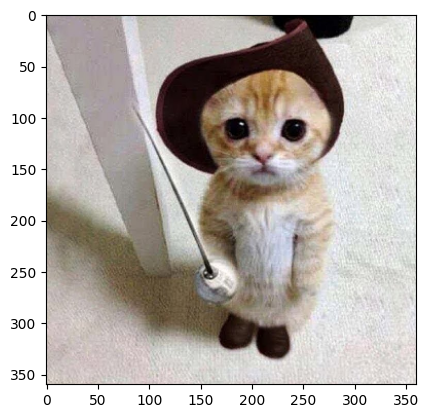

In [165]:
# Create input pixel coordinates in the unit square
coords = torch.linspace(-1 1, img.shape[0], device=device)
x_test = torch.stack(torch.meshgrid(coords, coords), -1).reshape(-1, 2)
img = torch.tensor(img).type_as(x_test)
test_data = [x_test, img]
train_data = [x_test[::4], img[::2, ::2].reshape(-1, 3)]
print(test_data[0].shape)
print(img.shape)
print(train_data[0].shape)
print(train_data[1].shape)
plt.imshow(train_data[1].reshape(360, 360, 3).cpu())
plt.show()

In [184]:
model2d = BeamNet(input_dim=2, output_dim=3,
                  # hidden_dims=['#16,16,512', 256],
                  hidden_dims=[256]*4,
                  sigmoid_output=True,
                  activation=nn.ReLU()) # L, F, N_max
# model = BeamNet(input_dim=1, output_dim=1, hidden_dims=[256, 256]*4) # L, F, N_max

model2d = model2d.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()

# plt.imshow(model.net[2].features[0].detach().numpy())

activations, gradients = {}, {}

for name, layer in model2d.net.named_modules():
  if type(layer) == nn.Linear or type(layer) == BeamLayer:
    layer.register_forward_hook(save_activation(name))
    layer.register_full_backward_hook(save_gradients(name))

BeamNet(
  (net): Sequential(
    (fc_0): Linear(in_features=2, out_features=256, bias=True)
    (act_0): ReLU()
    (fc_1): Linear(in_features=256, out_features=256, bias=True)
    (act_1): ReLU()
    (fc_2): Linear(in_features=256, out_features=256, bias=True)
    (act_2): ReLU()
    (fc_3): Linear(in_features=256, out_features=256, bias=True)
    (act_3): ReLU()
    (fc_final): Linear(in_features=256, out_features=3, bias=True)
    (sigmoid_out): Sigmoid()
  )
)
198915


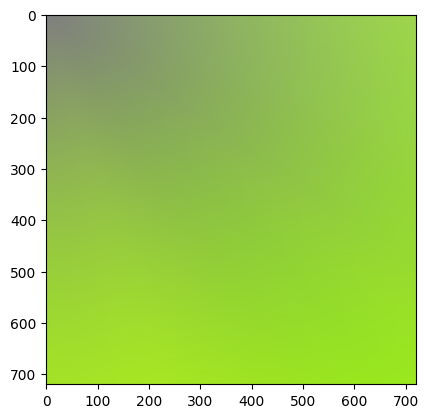

In [188]:
print(model2d)
print(np.sum([p.numel() for p in model2d.parameters()]))
pred = model2d(test_data[0]).reshape(720,720,3)
plt.imshow(pred.cpu().detach().numpy())
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Loss: 0.1209205612540245


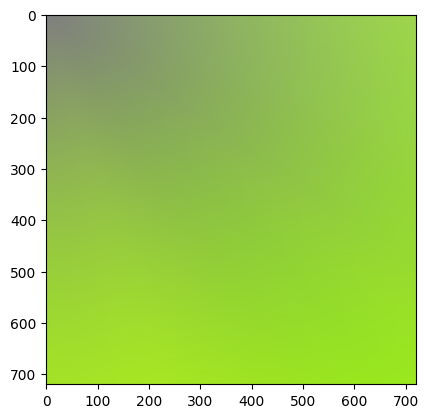

  4%|▍         | 20/500 [00:12<03:53,  2.06it/s]

Epoch 20 | Loss: 0.1209205612540245


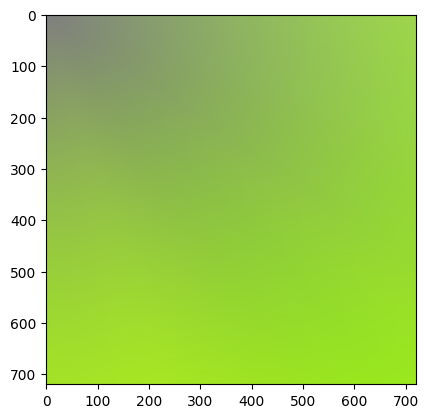

  8%|▊         | 40/500 [00:24<03:45,  2.04it/s]

Epoch 40 | Loss: 0.1209205612540245


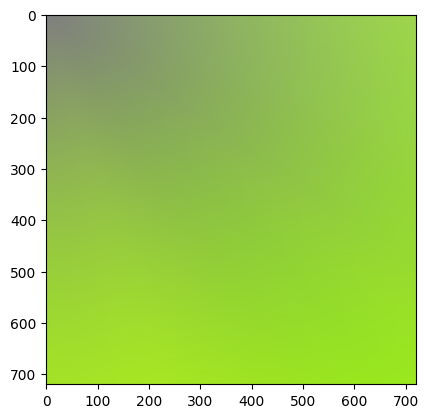

  9%|▊         | 43/500 [00:28<05:00,  1.52it/s]


KeyboardInterrupt: 

In [186]:
from tqdm import tqdm

feature_map_grads = []
linear_grad = []

epochs = 500

for epoch in tqdm(range(epochs)):
  model2d.train()
  optimizer.zero_grad()

  pred = model2d(train_data[0])
  model_loss = loss(pred, train_data[1])

  model_loss.backward()
  optimizer.step()

  with torch.no_grad():
    # for param in model.net[2].features.parameters():
    #   if param.grad is not None:
    #     feature_map_grads.append(param.grad.norm().item())
    # if model.net[0].weight.grad is not None:
    #   linear_grad.append(model.net[1].weight.norm().item())

    if (epoch % 20) == 0:
        print(f'Epoch {epoch} | Loss: {model_loss}')
        test_pred = model2d(test_data[0]).reshape(720, 720, 3)
        plt.imshow(test_pred.cpu().detach().numpy())
        plt.show()


model2d.eval()

# plt.plot(X_test, model2d(X_test.to(device)).cpu().detach().numpy())
# plt.plot(train_data[0].cpu(), train_data[1].cpu(), '.')
# plt.show()
# plt.imshow(model.net[2].features[0].detach().cpu().numpy())
